{% include toc title="On This Page" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-ship" aria-hidden="true"></i> Subtract Raster Data in Open Source Python 

After completing this tutorial, you will be able to:
* Derive a **Canopy Height Model** in `Python` using a Digital Elevation Model and a Digital Surface Model derived from Lidar data. 
* Subtract one raster layer from another using raster math and open source Python.

## <i class="fa fa-check-square-o fa-2" aria-hidden="true"></i> What You Need

You will need a computer with internet access to complete this lesson and a working version of python version 3.x.

{% include/data_subsets/course_earth_analytics/_data-colorado-flood.md %}

</div>

Often you need to process two raster datasets together to create a new raster output and then save that output as a new file. In this lesson, you will learn how to subtract rasters and create a new GeoTIFF file in open source **Python** using **rasterio**.

Begin by importing the necessary packages, downloading data, and setting the working directory.

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import rasterio as rio
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 
                      'earth-analytics', 
                      'data'))

Open and plot the lidar digital elevation model (DEM). Note that when you read the data, you can use the argument `masked = True` to ensure that the no data values do not plot and are assigned `nan` or `nodata`. 

<!-- 
If we use masked=True we can skip this step
# Insert nans
#lidar_dem_im[lidar_dem_im == lidar_dem.nodata] = np.nan
-->

In [2]:
# Define relative path to file
lidar_dem_path = os.path.join("colorado-flood", 
                              "spatial", 
                              "boulder-leehill-rd", 
                              "pre-flood", 
                              "lidar",
                              "pre_DTM.tif")

# Open raster data
with rio.open(lidar_dem_path) as lidar_dem:
    lidar_dem_im = lidar_dem.read(1, masked=True)
    
    # Get bounds for plotting
    bounds = plotting_extent(lidar_dem)

### Import Digital Surface Model (DSM)

Next, you will open the digital surface model (DSM). The DSM represents the top of
the earth's surface. Thus, it includes trees, buildings and other objects that
sit on the earth.

In [3]:
# Define relative path to file
lidar_dsm_path = os.path.join("colorado-flood", 
                              "spatial", 
                              "boulder-leehill-rd", 
                              "pre-flood", 
                              "lidar",
                              "pre_DSM.tif")

with rio.open(lidar_dsm_path) as lidar_dsm:
    lidar_dsm_im = lidar_dsm.read(1, masked=True)
    
lidar_dsm_im

masked_array(
  data=[[--, --, --, ..., 1695.6300048828125, 1695.5899658203125,
         1696.3900146484375],
        [--, --, --, ..., 1695.5999755859375, 1695.6300048828125, 1697.0],
        [--, --, --, ..., 1695.3800048828125, 1695.43994140625,
         1695.449951171875],
        ...,
        [--, --, --, ..., 1681.449951171875, 1681.3900146484375, 1681.25],
        [--, --, --, ..., 1681.719970703125, 1681.5699462890625,
         1681.5599365234375],
        [--, --, --, ..., 1681.8900146484375, 1681.8099365234375,
         1681.739990234375]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-3.402823e+38,
  dtype=float32)


## Canopy Height Model

The canopy height model (CHM) represents the HEIGHT of the trees. This is not an elevation value, rather it's the height or distance between the ground and the top of the trees (or buildings or whatever object that the lidar system detected and recorded). 

Some canopy height models also include buildings, so you need to look closely at your data to make sure it was properly cleaned before assuming it represents all trees!

### Calculate difference between two rasters

There are different ways to calculate a CHM. One easy way is to subtract the
DEM from the DSM.

**DSM - DEM = CHM**

This math gives you the residual value or difference between the top of the
earth surface and the ground which should be the heights of the trees (and buildings
if the data haven't been "cleaned").

<i class="fa fa-star"></i> **Data Tip:** Note that this method of subtracting 2 rasters to create a CHM may not give you the most accurate results! There are better ways to create CHM's using the point clouds themselves. However, in this lesson you learn this method as a means to get more familiar with the CHM dataset and to understand how to perform raster calculations in `Python`. 
{: .notice--success}

Before you subtract the two rasters, be sure to check to see if they cover the same area.

In [4]:
# Are the bounds the same?
print("Is the spatial extent the same?", 
      lidar_dem.bounds == lidar_dsm.bounds)

# Is the resolution the same ??
print("Is the resolution the same?", 
      lidar_dem.res == lidar_dsm.res)

Is the spatial extent the same? True
Is the resolution the same? True


It looks like the bounds and resolution are the same. This means it is safe for you to subtract the two rasters without significant errors or uncertainty introduced. 

In [5]:
# Calculate canopy height model
lidar_chm_im = lidar_dsm_im - lidar_dem_im

Finally, plot your newly created canopy height model.

In [6]:
#how i was previously scaling colorbars... 
# the earthpy colorbar function is problematic for a few different reasons - it doesn't play nicely with rasterio show...
# but maybe i can fix that in the future..
# scale color bar to the height of the plot
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="3%", pad=0.15)

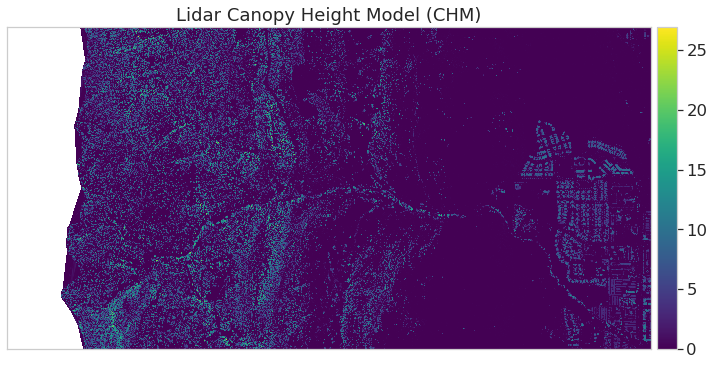

In [7]:
# Plot the data
ep.plot_bands(lidar_chm_im, 
              cmap='viridis',
              title="Lidar Canopy Height Model (CHM)",
              scale=False)
plt.show()

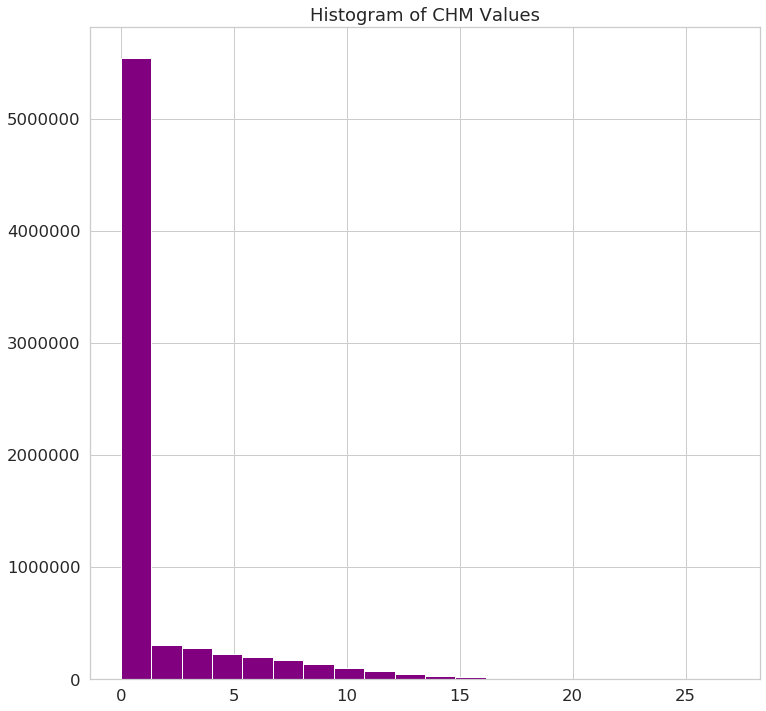

In [22]:
ep.hist(lidar_chm_im, 
        colors = 'purple',
        title="Histogram of CHM Values")
plt.show()

Take a close look at the CHM plot. Do you think that the data just represents trees? Or do you see anything that may suggest that there are other types of objects represented in the data?


### Explore the CHM Data

Next, explore the data values in your CHM. Think about the values representing things like trees and buildings in your data.

Do the data make sense?

In [9]:
print('CHM minimum value: ', lidar_chm_im.min())
print('CHM max value: ', lidar_chm_im.max())

CHM minimum value:  0.0
CHM max value:  26.930054


## Export a Raster

You can export a raster file in `python` using the `rasterio` `write()` function. Export the canopy height model that you just created to your data folder. You will create a new directory called "outputs" within the `colorado-flood` directory. This structure allows you to keep things organized, separating your outputs from the data you downloaded.

NOTE: you can use the code below to check for and create an outputs directory. OR, you can create the directory yourself using the finder (MAC) or windows
explorer.

In [10]:
if os.path.exists('data/colorado-flood/spatial/outputs'):
    print('The directory exists!')
else:
    os.makedirs('data/colorado-flood/spatial/outputs')

The directory exists!


### Exporting Numpy Arrays to Geotiffs

Next, you need to consider the metdata associated with your chm. Remember that the chm was generated using 2 numpy arrays. Neither of these arrays has spatial data directly associated with it. BUT you do have the rasterio object that has metadata that you can use if you want to assign all of the spatial attributes that are needed to save a usable geotiff file.

You can use the syntax

`**dictionary-metadata-object-here` 

to apply all of the spatial attributes from one of your raster objects, when you write out your new chm raster.

To begin, have a look at the lidar_dem metadata dictionary. Looking at the example below, all of the metadata in that dictionary are the same as what we expect the output chm to have. Thus we can use the metadata as they are. 

In [11]:
lidar_dem.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 4000,
 'height': 2000,
 'count': 1,
 'crs': CRS.from_epsg(32613),
 'transform': Affine(1.0, 0.0, 472000.0,
        0.0, -1.0, 4436000.0)}

Next, update the `nodata` value. The number being used currently is difficult to remember. A more standard value like `-999.99` could be a better option. To implement this we will do two things

1. You will assign all masked pixels values which represent `nodata` values to -999.99 using the `np.ma.filled()` function.
2. Then you will create a new metadata dictionary that contained the updated nodata value.

In [12]:
lidar_chm_im.min()
lidar_chm_im

masked_array(
  data=[[--, --, --, ..., 0.0, 0.1700439453125, 0.9600830078125],
        [--, --, --, ..., 0.0, 0.090087890625, 1.6400146484375],
        [--, --, --, ..., 0.0, 0.0, 0.0799560546875],
        ...,
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-3.402823e+38,
  dtype=float32)

In [13]:
# fill the masked pixels with a set no data value
nodatavalue = -999.0
lidar_chm_im_fi = np.ma.filled(lidar_chm_im, fill_value=nodatavalue)
lidar_chm_im_fi.min(), nodatavalue

(-999.0, -999.0)

Then update the metadata dictionary. 

In [14]:
# Update the metadata to ensure the nodata value is properly documented 

# Create dictionary copy
chm_meta = lidar_dem.meta.copy()

# Update the nodata value to be an easier to use number
chm_meta.update({'nodata': nodatavalue})
chm_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -999.0,
 'width': 4000,
 'height': 2000,
 'count': 1,
 'crs': CRS.from_epsg(32613),
 'transform': Affine(1.0, 0.0, 472000.0,
        0.0, -1.0, 4436000.0)}

If you want, you can check things like the shape of the numpy array to ensure that it is the same as the width and height of the dem. It should be! 

In [15]:
# Note the width and height of the dem above. 
# Is the numpy array shape the same?
lidar_chm_im_fi.shape

(2000, 4000)

Finally, you can export your raster layer. Below you do the following

1. you use the same `rio.open()` syntax that you are used to using except now you specify that you are writing a new file with the 'w' argument.
2. you specify the new file name and destination in the `rio.open()` function eg: `'data/colorado-flood/spatial/outputs/lidar_chm.tiff'`
2. you specify the metadata as an "unpacked" dictionary using `**lidar_dem.meta` - doing this allows you to NOT have to specify EACH and EVERY metadata element individually in your output statement - which would be tedious!
3. finally you write the file. `output_file.write(your-object-name, layer)`  Notice that when you make this call you specify both the object name and the layer that you wish to write to a new file. Also notice the `outf` is the name of the rasterio object as defined below. 

In [16]:
out_path = os.path.join("colorado-flood", 
                        "spatial",
                        "outputs", 
                        "lidar_chm.tif")

with rio.open(out_path, 'w', **chm_meta) as outf:
    outf.write(lidar_chm_im_fi, 1)

<div class="notice--warning" markdown="1">

## <i class="fa fa-pencil-square-o" aria-hidden="true"></i> Optional Challenge

Practice your skills. Open the lidar_chm GeoTIFF file that you just created. 
Do the following:

1. View the crs - is it correct?
2. View the x and y spatial resolution. 
3. Plot the data using a color bar of your choice. 

Your plot should look like the one below (athough the colors may be different.
</div>

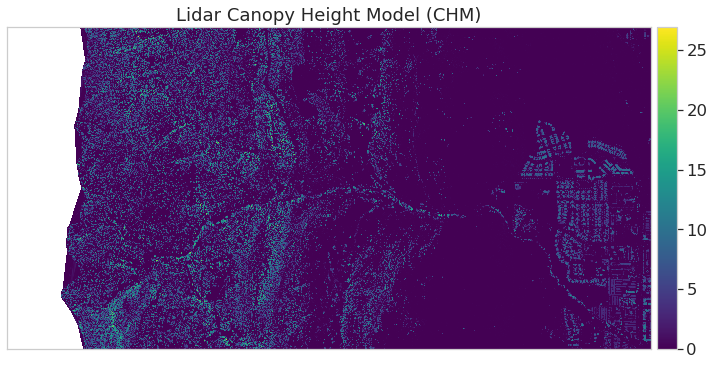

In [17]:
# Import the data
with rio.open(out_path) as lidar_chm:
    lidar_chm_im = lidar_chm.read(1, masked=True)

ep.plot_bands(lidar_chm_im,
              cmap='viridis',
              extent=plotting_extent(lidar_chm),
              title="Lidar Canopy Height Model (CHM)",
              scale=False)
plt.show()

<div class="notice--success" markdown="1">

<i class="fa fa-star" aria-hidden="true"></i> **Data Tip:** You can simplify the directory code above by using the exclamation `not` which tells Python to return the INVERSE or opposite of the function you have requested Python to run.

</div>